# Tarea 4

## Redes Neuronales

### María José Liberona Tobar

In [1]:
#Tarea 4 María José Liberona
#Importación de librerías 
import pandas as pd
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sb

import sys

## Subir datasets de fallas de corriente

In [2]:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea4_train.txt

Saving sensorless_tarea4_train.txt to sensorless_tarea4_train.txt


In [3]:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea4_test.txt

Saving sensorless_tarea4_test.txt to sensorless_tarea4_test.txt


## Leer datasets de fallas de corriente

In [4]:
!ls #Muestra los archivos subidos

sample_data  sensorless_tarea4_test.txt  sensorless_tarea4_train.txt


In [5]:
column_names = ["feat" + str(i) for i in range(48)]
column_names.append("class")

In [6]:
df_train_val = pd.read_csv('sensorless_tarea4_train.txt', names = column_names)
df_train_val["class"] = df_train_val["class"] - 1

In [7]:
df_test = pd.read_csv('sensorless_tarea4_test.txt', names = column_names)
df_test["class"] = df_test["class"] - 1


## Crear modelo

In [8]:
model = nn.Sequential(
          nn.Linear(48, 11)
        )
model

Sequential(
  (0): Linear(in_features=48, out_features=11, bias=True)
)

In [9]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



## Crear datasets y dataloaders para pytorch

In [10]:
# Crear datasets

feats_train_val = df_train_val.to_numpy()[:,0:48].astype(np.float32)
labels_train_val = df_train_val.to_numpy()[:,48].astype(int)
dataset_train_val = [ {"features":feats_train_val[i,:], "labels":labels_train_val[i]} for i in range(feats_train_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:48].astype(np.float32)
labels_test = df_test.to_numpy()[:,48].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

n_train = int(df_train_val.shape[0]*0.85)
n_val = df_train_val.shape[0] - n_train

dataset_train, dataset_val = random_split(dataset_train_val, [n_train, n_val])

In [11]:
# Normalizar datos

fdata = []
i = 0

for x in dataset_train:
  fdata.append(x['features'])

fdata = np.array(fdata)

fmean= np.mean(fdata, axis=0)
fstd = np.std(fdata, axis=0)

for x in dataset_train:
  x['features'] = (x['features']-fmean) / fstd

for x in dataset_val:
  x['features'] = (x['features']-fmean) / fstd

for x in dataset_test:
  x['features'] = (x['features']-fmean) / fstd


In [12]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

# Parte 1: Código base
## Entrenamiento
Se puede interrumpir con: Entorno de Ejecución -> interrumpir la ejecución

In [13]:

for epoch in range(1000):
    try:
      sys.stdout.write("\rÉpoca %d  "  %(epoch))
      model.train()

      # Train on the current epoch
      perd_train=np.array([])
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)

          loss_t = criterion(outputs, labels)
          loss_t.backward() # Obtiene los gradientes y propaga
          optimizer.step() # Actualizan los pesos con los gradientes
           
          sys.stdout.write("\r Loss entrenamiento %s " %(loss_t.item()))
        
      # Compute validation loss and accuracy for current epoch
      model.eval()

      with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            # Calcular loss de validación
            loss_v=criterion(outputs, labels)
            sys.stdout.write("\r Loss validación %s " %(loss_v.item()))

      # Imprimir: numero de época, loss de entrenamiento y loss de validación
      # Se debe usar sys.stdout.write() para que la línea de texto se sobreescriba en vez de imprimirse línea por línea
      # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)

    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")
      break

print('\nEntrenamiento finalizado')

 Loss validación 0.27199792861938477 
Entrenamiento finalizado


# Parte 2

## Implementación redes neuronales

Época 350  Loss entrenamiento 0.10859292115156467 Loss validación 0.21710525453090668 
Entrenamiento finalizado
El tiempo de entrenamiento es: 16.603347301483154


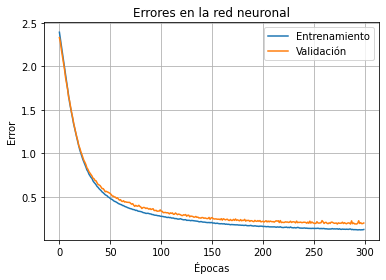

El mínimo error del conjunto de validación es: 0.19519733339548112


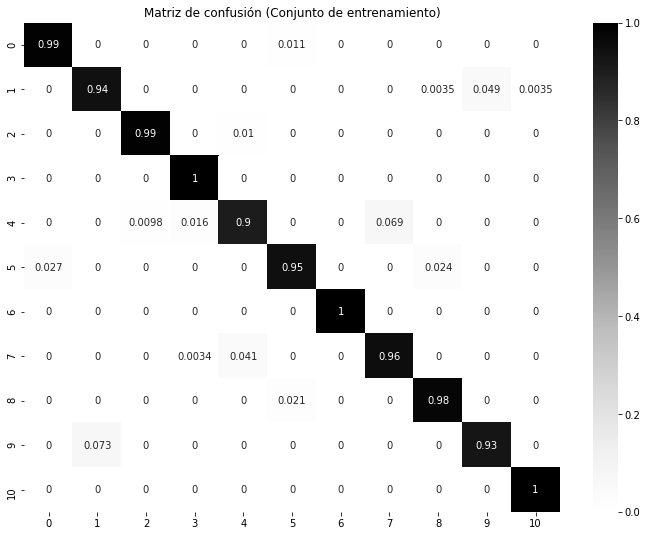

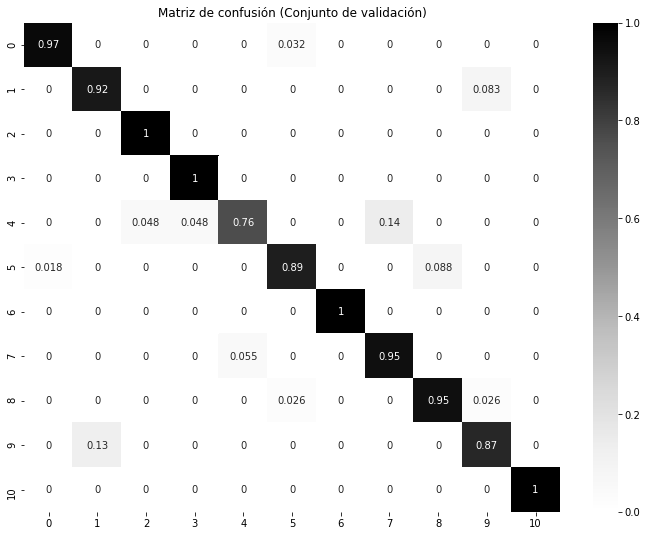

El accuracy del conjunto de entrenamiento es: 0.9665841584158416
El accuracy del conjunto de validación es: 0.9404553415061296


In [14]:
# a) Red neuronal con 10 neuronas en la capa oculta, usando la función de activación
# ReLu y 1000 épocas

# Crear modelo 
model_1 = nn.Sequential(
          nn.Linear(48, 10),
          nn.ReLU(),
          nn.Linear(10,11)
        )


# Función de pérdidas 
device_1 = torch.device('cuda')
model_1 = model_1.to(device_1)
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)

#Entrenamiento
loss1_train=np.array([]) #Almacena los errores de entrenamiento
loss1_val=np.array([]) #Almacena los errores de validación cada 50 épocas
loss11_val=np.array([]) #Almacena los errores de validación cada época

time1_0=time.time() #Hora inicial en segundos

for epoch in range(1000):
    try:
      model_1.train()

      # Train on the current epoch
      perd_train=np.array([])
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device_1)
          labels = data["labels"].to(device_1)
          # zero the parameter gradients
          optimizer_1.zero_grad()

          # forward + backward + optimize
          outputs = model_1(inputs)

          loss_t = criterion_1(outputs, labels)
          loss_t.backward() # Obtiene los gradientes y propaga
          optimizer_1.step() # Actualizan los pesos con los gradientes
          perd_train=np.append(perd_train,loss_t.item()) #Añade los errores a una lista
  
      prom_train=sum(perd_train)/len(perd_train)
      loss1_train=np.append(loss1_train,prom_train) 


      # Compute validation loss and accuracy for current epoch
      model_1.eval()

      if epoch%50==0:
        perd_val=np.array([]) 
      perd_val1=np.array([])  
      with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device_1)
            labels = data["labels"].to(device_1)
            outputs = model_1(inputs)
            # Calcular loss de validación
            loss_v=criterion_1(outputs, labels)
            perd_val=np.append(perd_val,loss_v.item()) #Almacena datos para el promedio cada 50 épocas
            perd_val1=np.append(perd_val1,loss_v.item()) #Almacena datos para el promedio cada época


      #Promedio error de validación cada época    
      prom_val1=sum(perd_val1)/len(perd_val1)
      loss11_val=np.append(loss11_val,prom_val1)

      #Muestra los erróres
      sys.stdout.write("\rÉpoca %d  "  %(epoch) + "Loss entrenamiento %s " %(prom_train) + "Loss validación %s " %(prom_val1))

      if epoch%50==0 or epoch==999:
        #Erorres del conjunto de validación
        prom_val=sum(perd_val)/len(perd_val)
        loss1_val=np.append(loss1_val,prom_val)  

        #Guarda la red neuronal cada 50 épocas 
        torch.save(model_1, 'model_1_'+str(epoch)+'.pt')

        #Análisis de aumento en los errores de validación 
        l=len(loss1_val)
        if loss1_val[l-1]>loss1_val[l-2]:
          epoch_break_1=epoch
          break

      # Imprimir: numero de época, loss de entrenamiento y loss de validación
      # Se debe usar sys.stdout.write() para que la línea de texto se sobreescriba en vez de imprimirse línea por línea
      # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)

    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")
      break

print('\nEntrenamiento finalizado')
time1_1=time.time() #Hora final en segundos
time_train1=time1_1-time1_0 #Tiempo de entrenamiento
print('El tiempo de entrenamiento es: '+str(time_train1))

#Gráfico de errores
t_train=np.array(range(0,epoch_break_1-50)) #Épocas de entrenamiento
t_val=np.array(range(0,epoch_break_1-50))  #Épocas de validación
plt.figure()
plt.plot(t_train,loss1_train[:epoch_break_1-50], label='Entrenamiento')
plt.plot(t_val,loss11_val[:epoch_break_1-50], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.title('Errores en la red neuronal')
plt.legend()
plt.grid()
plt.show()

#Mínimo del conjunto de validación
print('El mínimo error del conjunto de validación es: '+str(np.amin(loss1_val)))

#Cargar red neuronal entrenada cuando el error de validación es mínimo 
model1_op=torch.load('model_1_'+str(epoch_break_1-50)+'.pt')

y_pred1_train = []
y_true1_train = []
y_pred1_val = []
y_true1_val = []

model1_op.eval()

with torch.no_grad():

    #Evalua en el conjunto de entrenamiento
    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device_1)
        labels = data["labels"].to(device_1)
        outputs = model1_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred1_train.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true1_train.extend(labels) # Save Truth
    
    #Evalua en el conjunto de validación
    for i, data in enumerate(dataloader_val, 0):
        inputs = data["features"].to(device_1)
        labels = data["labels"].to(device_1)
        outputs = model1_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred1_val.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true1_val.extend(labels) # Save Truth

#Matriz de confusión (Conjunto de entrenamiento)
matriz_cf1_train = confusion_matrix(y_true1_train, y_pred1_train, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf1_train, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de entrenamiento)')
plt.show()

#Matriz de confusión (Conjunto de validación)
matriz_cf1_val = confusion_matrix(y_true1_val, y_pred1_val, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf1_val, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de validación)')
plt.show()

#Accuracy conjunto de entrenamiento
accuracy1_train=accuracy_score(y_true1_train,y_pred1_train, normalize=True)
print('El accuracy del conjunto de entrenamiento es: '+str(accuracy1_train))

#Accuracy conjunto de validación
accuracy1_val=accuracy_score(y_true1_val,y_pred1_val, normalize=True)
print('El accuracy del conjunto de validación es: '+str(accuracy1_val))



Época 250  Loss entrenamiento 0.017984206358400676 Loss validación 0.1399134173989296 
Entrenamiento finalizado
El tiempo de entrenamiento es: 11.833527565002441


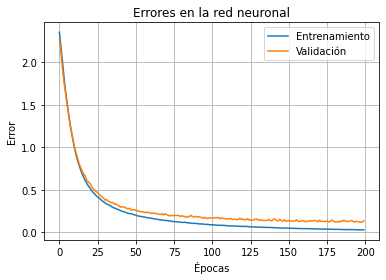

0.13915741592645645


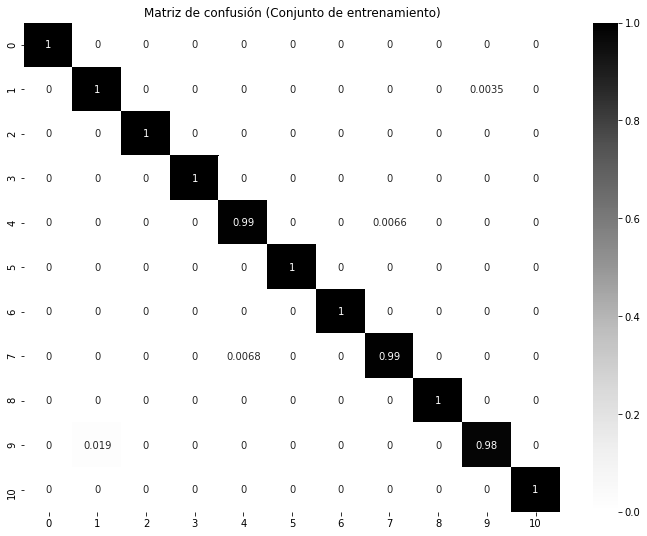

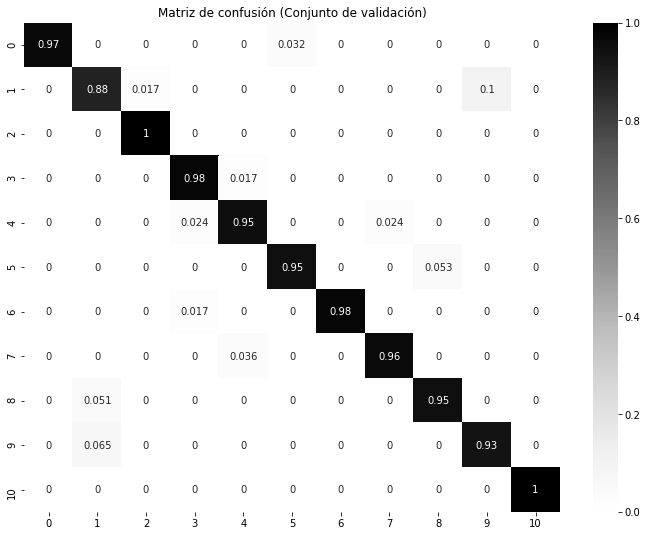

El accuracy del conjunto de entrenamiento es: 0.9965965346534653
El accuracy del conjunto de validación es: 0.9597197898423818


In [15]:
#  b) Red neuronal con 40 neuronas en la capa oculta, usando la función de activación
# ReLu y 1000 épocas

# Crear modelo 
model_2 = nn.Sequential(
          nn.Linear(48, 40),
          nn.ReLU(),
          nn.Linear(40,11)
        )


# Función de pérdidas 
device_2 = torch.device('cuda')
model_2 = model_2.to(device_2)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)

#Entrenamiento
loss2_train=np.array([]) #Almacena los errores de entrenamiento
loss2_val=np.array([]) #Almacena los errores de validación
loss22_val=np.array([]) #Almacena los errores de validación cada época

time2_0=time.time() #Hora inicial en segundos

for epoch in range(1000):
    try:
      model_2.train()

      # Train on the current epoch
      perd_train=np.array([])
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device_2)
          labels = data["labels"].to(device_2)
          # zero the parameter gradients
          optimizer_2.zero_grad()

          # forward + backward + optimize
          outputs = model_2(inputs)

          loss_t = criterion_2(outputs, labels)
          loss_t.backward() # Obtiene los gradientes y propaga
          optimizer_2.step() # Actualizan los pesos con los gradientes
          perd_train=np.append(perd_train,loss_t.item()) #Añade los errores a una lista
  
      prom_train=sum(perd_train)/len(perd_train)
      loss2_train=np.append(loss2_train,prom_train)  
      sys.stdout.write("\r Loss entrenamiento %s " %(prom_train))
        
      # Compute validation loss and accuracy for current epoch
      model_2.eval()

      if epoch%50==0:
        perd_val=np.array([]) 
      perd_val1=np.array([]) 
      with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device_2)
            labels = data["labels"].to(device_2)
            outputs = model_2(inputs)
            # Calcular loss de validación
            loss_v=criterion_2(outputs, labels)
            perd_val=np.append(perd_val,loss_v.item())
            perd_val1=np.append(perd_val1,loss_v.item())

      #Promedio error de validación cada época    
      prom_val1=sum(perd_val1)/len(perd_val1)
      loss22_val=np.append(loss22_val,prom_val1)

      #Muestra los erróres
      sys.stdout.write("\rÉpoca %d  "  %(epoch) + "Loss entrenamiento %s " %(prom_train) + "Loss validación %s " %(prom_val1))

      if epoch%50==0 or epoch==999:
        prom_val=sum(perd_val)/len(perd_val)
        loss2_val=np.append(loss2_val,prom_val)  

        #Guarda la red neuronal cada 50 épocas 
        torch.save(model_2, 'model_2_'+str(epoch)+'.pt')

        #Análisis de aumento en los errores de validación 
        l=len(loss2_val)
        if loss2_val[l-1]>loss2_val[l-2]:
          epoch_break_2=epoch
          break


      # Imprimir: numero de época, loss de entrenamiento y loss de validación
      # Se debe usar sys.stdout.write() para que la línea de texto se sobreescriba en vez de imprimirse línea por línea
      # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)

    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")
      break

print('\nEntrenamiento finalizado')
time2_1=time.time() #Hora final en segundos
time_train2=time2_1-time2_0 #Tiempo de entrenamiento
print('El tiempo de entrenamiento es: '+str(time_train2))

#Gráfico de errores
t_train=np.array(range(0,epoch_break_2-50)) #Épocas de entrenamiento
t_val=np.array(range(0,epoch_break_2-50))  #Épocas de validación
plt.plot(t_train,loss2_train[:epoch_break_2-50], label='Entrenamiento')
plt.plot(t_val,loss22_val[:epoch_break_2-50], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.title('Errores en la red neuronal')
plt.legend()
plt.grid()
plt.show()

#Mínimo del conjunto de validación
print(np.amin(loss2_val))

#Cargar red neuronal entrenada cuando el error de validación es mínimo 
model2_op=torch.load('model_2_'+str(epoch_break_2-50)+'.pt')

y_pred2_train = []
y_true2_train = []
y_pred2_val = []
y_true2_val = []

model2_op.eval()

with torch.no_grad():

    #Evalua en el conjunto de entrenamiento
    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device_2)
        labels = data["labels"].to(device_2)
        outputs = model2_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred2_train.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true2_train.extend(labels) # Save Truth
    
    #Evalua en el conjunto de validación
    for i, data in enumerate(dataloader_val, 0):
        inputs = data["features"].to(device_2)
        labels = data["labels"].to(device_2)
        outputs = model2_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred2_val.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true2_val.extend(labels) # Save Truth

#Matriz de confusión (Conjunto de entrenamiento)
matriz_cf2_train = confusion_matrix(y_true2_train, y_pred2_train, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf2_train, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de entrenamiento)')
plt.show()

#Matriz de confusión (Conjunto de validación)
matriz_cf2_val = confusion_matrix(y_true2_val, y_pred2_val, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf2_val, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de validación)')
plt.show()

#Accuracy conjunto de entrenamiento
accuracy2_train=accuracy_score(y_true2_train,y_pred2_train, normalize=True)
print('El accuracy del conjunto de entrenamiento es: '+str(accuracy2_train))

#Accuracy conjunto de validación
accuracy2_val=accuracy_score(y_true2_val,y_pred2_val, normalize=True)
print('El accuracy del conjunto de validación es: '+str(accuracy2_val))



Época 450  Loss entrenamiento 0.13842828571796417 Loss validación 0.22459299564361573 
Entrenamiento finalizado
El tiempo de entrenamiento es: 21.374253034591675


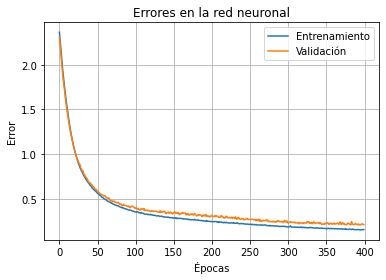

0.20956547260284425


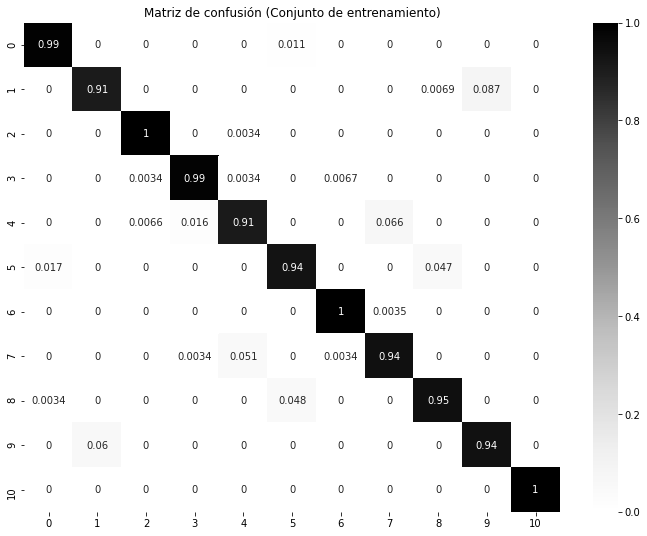

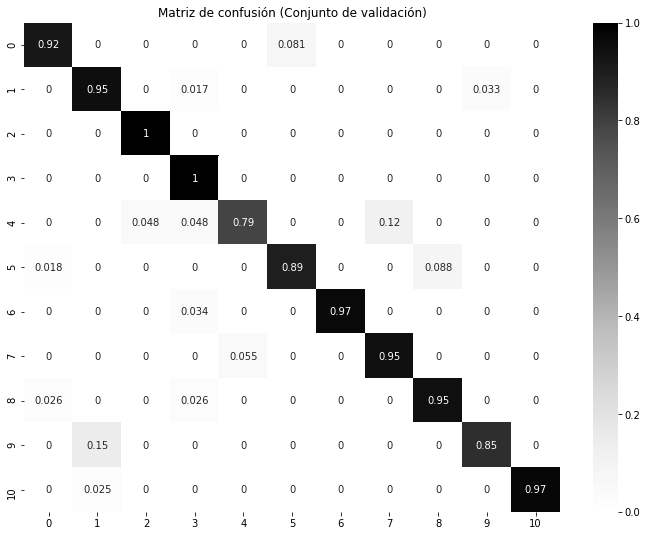

El accuracy del conjunto de entrenamiento es: 0.9588490099009901
El accuracy del conjunto de validación es: 0.9334500875656743


In [16]:
# c) Red neuronal con 10 neuronas en la capa oculta, usando la función de activación
# Tanh y 1000 épocas

# Crear modelo 
model_3 = nn.Sequential(
          nn.Linear(48, 10),
          nn.Tanh(),
          nn.Linear(10,11)
        )


# Función de pérdidas 
device_3 = torch.device('cuda')
model_3 = model_3.to(device_3)
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=1e-3)

#Entrenamiento
loss3_train=np.array([]) #Almacena los errores de entrenamiento
loss3_val=np.array([]) #Almacena los errores de validación
loss33_val=np.array([]) #Almacena los errores de validación cada época

time3_0=time.time() #Hora inicial en segundos

for epoch in range(1000):
    try:
      model_3.train()

      # Train on the current epoch
      perd_train=np.array([])
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device_3)
          labels = data["labels"].to(device_3)
          # zero the parameter gradients
          optimizer_3.zero_grad()

          # forward + backward + optimize
          outputs = model_3(inputs)

          loss_t = criterion_3(outputs, labels)
          loss_t.backward() # Obtiene los gradientes y propaga
          optimizer_3.step() # Actualizan los pesos con los gradientes
          perd_train=np.append(perd_train,loss_t.item()) #Añade los errores a una lista
  
      prom_train=sum(perd_train)/len(perd_train)
      loss3_train=np.append(loss3_train,prom_train)  
        
      # Compute validation loss and accuracy for current epoch
      model_3.eval()

      if epoch%50==0:
        perd_val=np.array([])
      perd_val1=np.array([]) 
      with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device_3)
            labels = data["labels"].to(device_3)
            outputs = model_3(inputs)
            # Calcular loss de validación
            loss_v=criterion_3(outputs, labels)
            perd_val=np.append(perd_val,loss_v.item())
            perd_val1=np.append(perd_val1,loss_v.item())


      #Promedio error de validación cada época    
      prom_val1=sum(perd_val1)/len(perd_val1)
      loss33_val=np.append(loss33_val,prom_val1)
      sys.stdout.write("\r Loss validación %s " %(prom_val1))

      #Muestra los erróres
      sys.stdout.write("\rÉpoca %d  "  %(epoch) + "Loss entrenamiento %s " %(prom_train) + "Loss validación %s " %(prom_val1))

      if epoch%50==0 or epoch==999:
        prom_val=sum(perd_val)/len(perd_val)
        loss3_val=np.append(loss3_val,prom_val)  
        
        #Guarda la red neuronal cada 50 épocas 
        torch.save(model_3, 'model_3_'+str(epoch)+'.pt')

        #Análisis de aumento en los errores de validación 
        l=len(loss3_val)
        if loss3_val[l-1]>loss3_val[l-2]:
          epoch_break_3=epoch
          break

      # Imprimir: numero de época, loss de entrenamiento y loss de validación
      # Se debe usar sys.stdout.write() para que la línea de texto se sobreescriba en vez de imprimirse línea por línea
      # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)

    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")
      break

print('\nEntrenamiento finalizado')
time3_1=time.time() #Hora final en segundos
time_train3=time3_1-time3_0 #Tiempo de entrenamiento
print('El tiempo de entrenamiento es: '+str(time_train3))
#Gráfico de errores
t_train=np.array(range(0,epoch_break_3-50)) #Épocas de entrenamiento
t_val=np.array(range(0,epoch_break_3-50))  #Épocas de validación
plt.plot(t_train,loss3_train[:epoch_break_3-50], label='Entrenamiento')
plt.plot(t_val,loss33_val[:epoch_break_3-50], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.title('Errores en la red neuronal')
plt.legend()
plt.grid()
plt.show()

#Mínimo del conjunto de validación
print(np.amin(loss3_val))

#Cargar red neuronal entrenada cuando el error de validación es mínimo 
model3_op=torch.load('model_3_'+str(epoch_break_3-50)+'.pt')

y_pred3_train = []
y_true3_train = []
y_pred3_val = []
y_true3_val = []

model3_op.eval()

with torch.no_grad():

    #Evalua en el conjunto de entrenamiento
    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device_3)
        labels = data["labels"].to(device_3)
        outputs = model3_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred3_train.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true3_train.extend(labels) # Save Truth
    
    #Evalua en el conjunto de validación
    for i, data in enumerate(dataloader_val, 0):
        inputs = data["features"].to(device_3)
        labels = data["labels"].to(device_3)
        outputs = model3_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred3_val.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true3_val.extend(labels) # Save Truth

#Matriz de confusión (Conjunto de entrenamiento)
matriz_cf3_train = confusion_matrix(y_true3_train, y_pred3_train, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf3_train, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de entrenamiento)')
plt.show()

#Matriz de confusión (Conjunto de validación)
matriz_cf3_val = confusion_matrix(y_true3_val, y_pred3_val, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf3_val, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de validación)')
plt.show()

#Accuracy conjunto de entrenamiento
accuracy3_train=accuracy_score(y_true3_train,y_pred3_train, normalize=True)
print('El accuracy del conjunto de entrenamiento es: '+str(accuracy3_train))

#Accuracy conjunto de validación
accuracy3_val=accuracy_score(y_true3_val,y_pred3_val, normalize=True)
print('El accuracy del conjunto de validación es: '+str(accuracy3_val))



Época 350  Loss entrenamiento 0.009871147949105272 Loss validación 0.12023441642522811 
Entrenamiento finalizado
El tiempo de entrenamiento es: 16.64071226119995


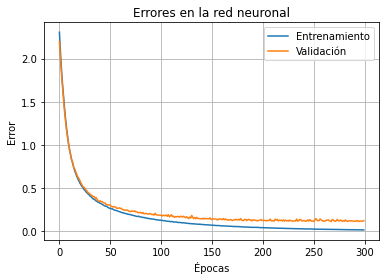

0.11143297590315342


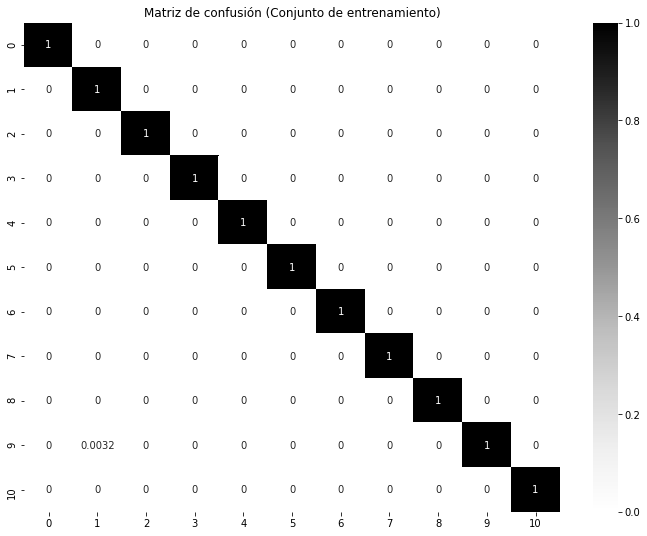

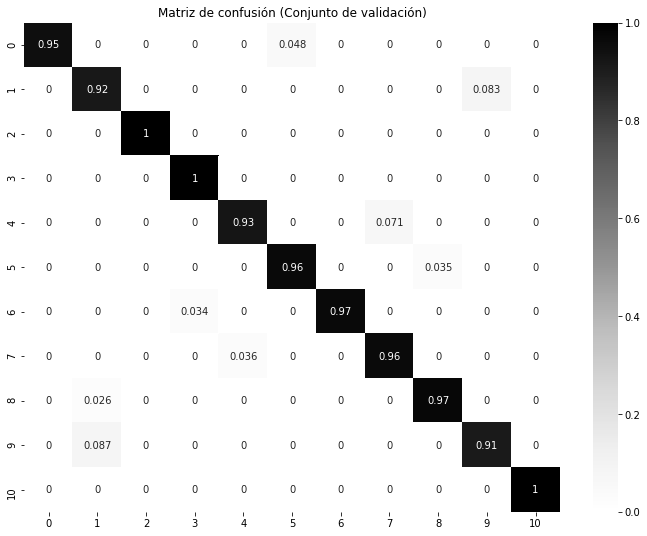

El accuracy del conjunto de entrenamiento es: 0.999690594059406
El accuracy del conjunto de validación es: 0.9614711033274956


In [17]:
# d) Red neuronal con 40 neuronas en la capa oculta, usando la función de activación
# Tanh y 1000 épocas

# Crear modelo 
model_4 = nn.Sequential(
          nn.Linear(48, 40),
          nn.Tanh(),
          nn.Linear(40,11)
        )


# Función de pérdidas 
device_4 = torch.device('cuda')
model_4 = model_4.to(device_4)
criterion_4 = nn.CrossEntropyLoss()
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=1e-3)

#Entrenamiento
loss4_train=np.array([]) #Almacena los errores de entrenamiento
loss4_val=np.array([]) #Almacena los errores de validación
loss44_val=np.array([]) #Almacena los errores de validación

time4_0=time.time() #Hora inicial en segundos

for epoch in range(1000):
    try:
      model_4.train()

      # Train on the current epoch
      perd_train=np.array([])
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device_4)
          labels = data["labels"].to(device_4)
          # zero the parameter gradients
          optimizer_4.zero_grad()

          # forward + backward + optimize
          outputs = model_4(inputs)

          loss_t = criterion_4(outputs, labels)
          loss_t.backward() # Obtiene los gradientes y propaga
          optimizer_4.step() # Actualizan los pesos con los gradientes
          perd_train=np.append(perd_train,loss_t.item()) #Añade los errores a una lista
  
      prom_train=sum(perd_train)/len(perd_train)
      loss4_train=np.append(loss4_train,prom_train)  
        
      # Compute validation loss and accuracy for current epoch
      model_4.eval()

      if epoch%50==0:
        perd_val=np.array([]) 
      perd_val1=np.array([]) 
      with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device_4)
            labels = data["labels"].to(device_4)
            outputs = model_4(inputs)
            # Calcular loss de validación
            loss_v=criterion_4(outputs, labels)
            perd_val=np.append(perd_val,loss_v.item())
            perd_val1=np.append(perd_val1,loss_v.item())

      
      #Promedio error de validación cada época    
      prom_val1=sum(perd_val1)/len(perd_val1)
      loss44_val=np.append(loss44_val,prom_val1)
      sys.stdout.write("\r Loss validación %s " %(prom_val1))

      #Muestra los erróres
      sys.stdout.write("\rÉpoca %d  "  %(epoch) + "Loss entrenamiento %s " %(prom_train) + "Loss validación %s " %(prom_val1))

      if epoch%50==0 or epoch==999:
        prom_val=sum(perd_val)/len(perd_val)
        loss4_val=np.append(loss4_val,prom_val)  

        #Guarda la red neuronal cada 50 épocas 
        torch.save(model_4, 'model_4_'+str(epoch)+'.pt')

        #Análisis de aumento en los errores de validación 
        l=len(loss4_val)
        if loss4_val[l-1]>loss4_val[l-2]:
          epoch_break_4=epoch
          break

      # Imprimir: numero de época, loss de entrenamiento y loss de validación
      # Se debe usar sys.stdout.write() para que la línea de texto se sobreescriba en vez de imprimirse línea por línea
      # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)

    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")
      break

print('\nEntrenamiento finalizado')
time4_1=time.time() #Hora final en segundos
time_train4=time4_1-time4_0 #Tiempo de entrenamiento
print('El tiempo de entrenamiento es: '+str(time_train4))

#Gráfico de errores
t_train=np.array(range(0,epoch_break_4-50)) #Épocas de entrenamiento
t_val=np.array(range(0,epoch_break_4-50))  #Épocas de validación
plt.plot(t_train,loss4_train[:epoch_break_4-50], label='Entrenamiento')
plt.plot(t_val,loss44_val[:epoch_break_4-50], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.title('Errores en la red neuronal')
plt.legend()
plt.grid()
plt.show()

#Mínimo del conjunto de validación
print(np.amin(loss4_val))

#Cargar red neuronal entrenada cuando el error de validación es mínimo 
model4_op=torch.load('model_4_'+str(epoch_break_4-50)+'.pt')

y_pred4_train = []
y_true4_train = []
y_pred4_val = []
y_true4_val = []

model4_op.eval()

with torch.no_grad():

    #Evalua en el conjunto de entrenamiento
    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device_4)
        labels = data["labels"].to(device_4)
        outputs = model4_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred4_train.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true4_train.extend(labels) # Save Truth
    
    #Evalua en el conjunto de validación
    for i, data in enumerate(dataloader_val, 0):
        inputs = data["features"].to(device_4)
        labels = data["labels"].to(device_4)
        outputs = model4_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred4_val.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true4_val.extend(labels) # Save Truth

#Matriz de confusión (Conjunto de entrenamiento)
matriz_cf4_train = confusion_matrix(y_true4_train, y_pred4_train, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf4_train, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de entrenamiento)')
plt.show()

#Matriz de confusión (Conjunto de validación)
matriz_cf4_val = confusion_matrix(y_true4_val, y_pred4_val, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf4_val, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de validación)')
plt.show()

#Accuracy conjunto de entrenamiento
accuracy4_train=accuracy_score(y_true4_train,y_pred4_train, normalize=True)
print('El accuracy del conjunto de entrenamiento es: '+str(accuracy4_train))

#Accuracy conjunto de validación
accuracy4_val=accuracy_score(y_true4_val,y_pred4_val, normalize=True)
print('El accuracy del conjunto de validación es: '+str(accuracy4_val))



Época 200  Loss entrenamiento 0.10029161463563259 Loss validación 0.2288024216890335 
Entrenamiento finalizado
El tiempo de entrenamiento es: 11.127975940704346


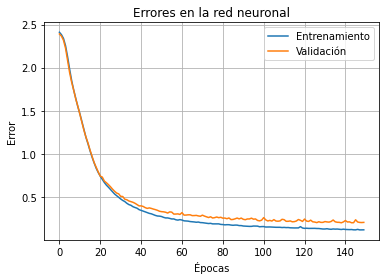

0.20163905322551728


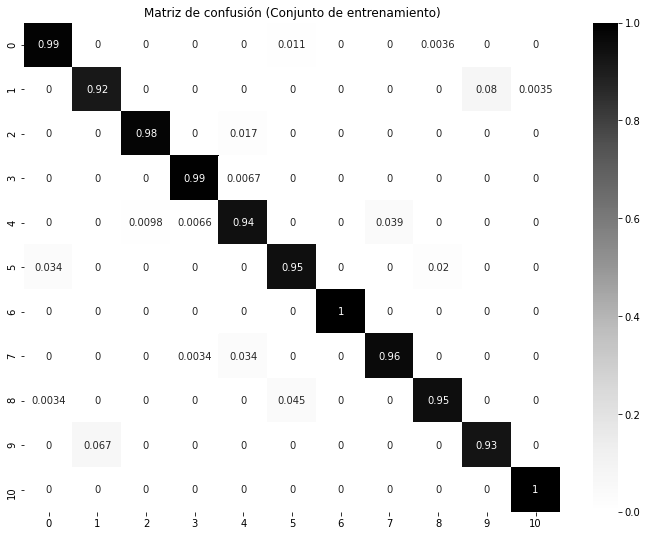

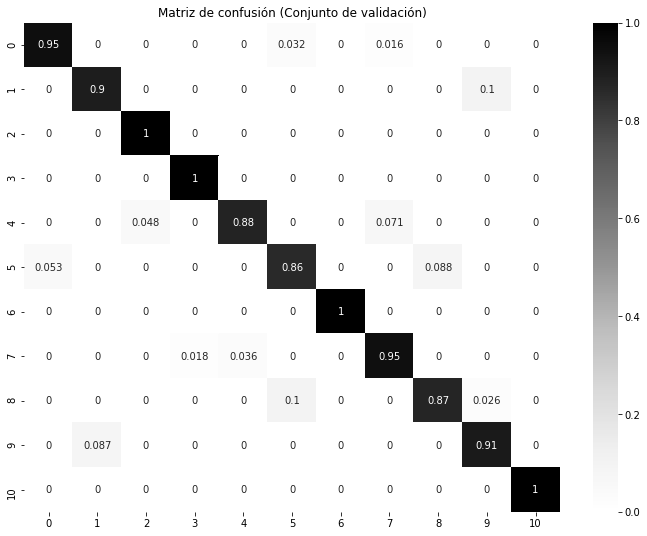

El accuracy del conjunto de entrenamiento es: 0.9647277227722773
El accuracy del conjunto de validación es: 0.9404553415061296


In [18]:
# e) 2 capas ocultas con 10 y 10 neuronas cada una y función de activación 
# ReLU, y 1000 épocas 

# Crear modelo 
model_5 = nn.Sequential(
          nn.Linear(48,10),
          nn.ReLU(),
          nn.Linear(10,10),
          nn.ReLU(),
          nn.Linear(10,11)
        )


# Función de pérdidas 
device_5 = torch.device('cuda')
model_5 = model_5.to(device_5)
criterion_5 = nn.CrossEntropyLoss()
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=1e-3)

#Entrenamiento
loss5_train=np.array([]) #Almacena los errores de entrenamiento
loss5_val=np.array([]) #Almacena los errores de validación
loss55_val=np.array([]) #Almacena los errores de validación

time5_0=time.time() #Hora inicial en segundos

for epoch in range(1000):
    try:
      model_5.train()

      # Train on the current epoch
      perd_train=np.array([])
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device_5)
          labels = data["labels"].to(device_5)
          # zero the parameter gradients
          optimizer_5.zero_grad()

          # forward + backward + optimize
          outputs = model_5(inputs)

          loss_t = criterion_5(outputs, labels)
          loss_t.backward() # Obtiene los gradientes y propaga
          optimizer_5.step() # Actualizan los pesos con los gradientes
          perd_train=np.append(perd_train,loss_t.item()) #Añade los errores a una lista
  
      prom_train=sum(perd_train)/len(perd_train)
      loss5_train=np.append(loss5_train,prom_train)  
        
      # Compute validation loss and accuracy for current epoch
      model_5.eval()

      if epoch%50==0:
        perd_val=np.array([]) 
      perd_val1=np.array([]) 
      with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device_5)
            labels = data["labels"].to(device_5)
            outputs = model_5(inputs)
            # Calcular loss de validación
            loss_v=criterion_5(outputs, labels)
            perd_val=np.append(perd_val,loss_v.item())
            perd_val1=np.append(perd_val1,loss_v.item())
            

      
      #Promedio error de validación cada época    
      prom_val1=sum(perd_val1)/len(perd_val1)
      loss55_val=np.append(loss55_val,prom_val1)

      #Muestra los erróres
      sys.stdout.write("\rÉpoca %d  "  %(epoch) + "Loss entrenamiento %s " %(prom_train) + "Loss validación %s " %(prom_val1))

      if epoch%50==0 or epoch==999:
        prom_val=sum(perd_val)/len(perd_val)
        loss5_val=np.append(loss5_val,prom_val)  

        #Guarda la red neuronal cada 50 épocas 
        torch.save(model_5, 'model_5_'+str(epoch)+'.pt')

        #Análisis de aumento en los errores de validación 
        l=len(loss5_val)
        if loss5_val[l-1]>loss5_val[l-2]:
          epoch_break_5=epoch
          break

      # Imprimir: numero de época, loss de entrenamiento y loss de validación
      # Se debe usar sys.stdout.write() para que la línea de texto se sobreescriba en vez de imprimirse línea por línea
      # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)

    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")
      break

print('\nEntrenamiento finalizado')
time5_1=time.time() #Hora final en segundos
time_train5=time5_1-time5_0 #Tiempo de entrenamiento
print('El tiempo de entrenamiento es: '+str(time_train5))

#Gráfico de errores
t_train=np.array(range(0,epoch_break_5-50)) #Épocas de entrenamiento
t_val=np.array(range(0,epoch_break_5-50))  #Épocas de validación
plt.plot(t_train,loss5_train[:epoch_break_5-50], label='Entrenamiento')
plt.plot(t_val,loss55_val[:epoch_break_5-50], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.title('Errores en la red neuronal')
plt.legend()
plt.grid()
plt.show()

#Mínimo del conjunto de validación
print(np.amin(loss5_val))

#Cargar red neuronal entrenada cuando el error de validación es mínimo 
model5_op=torch.load('model_5_'+str(epoch_break_5-50)+'.pt')

y_pred5_train = []
y_true5_train = []
y_pred5_val = []
y_true5_val = []

model5_op.eval()

with torch.no_grad():

    #Evalua en el conjunto de entrenamiento
    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device_5)
        labels = data["labels"].to(device_5)
        outputs = model5_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred5_train.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true5_train.extend(labels) # Save Truth
    
    #Evalua en el conjunto de validación
    for i, data in enumerate(dataloader_val, 0):
        inputs = data["features"].to(device_5)
        labels = data["labels"].to(device_5)
        outputs = model5_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred5_val.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true5_val.extend(labels) # Save Truth

#Matriz de confusión (Conjunto de entrenamiento)
matriz_cf5_train = confusion_matrix(y_true5_train, y_pred5_train, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf5_train, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de entrenamiento)')
plt.show()

#Matriz de confusión (Conjunto de validación)
matriz_cf5_val = confusion_matrix(y_true5_val, y_pred5_val, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf5_val, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de validación)')
plt.show()

#Accuracy conjunto de entrenamiento
accuracy5_train=accuracy_score(y_true5_train,y_pred5_train, normalize=True)
print('El accuracy del conjunto de entrenamiento es: '+str(accuracy5_train))

#Accuracy conjunto de validación
accuracy5_val=accuracy_score(y_true5_val,y_pred5_val, normalize=True)
print('El accuracy del conjunto de validación es: '+str(accuracy5_val))



Época 100  Loss entrenamiento 0.01789579064083787 Loss validación 0.13866134993731977 
Entrenamiento finalizado
El tiempo de entrenamiento es: 5.648935079574585


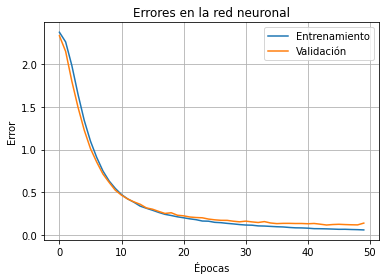

0.12173886001110076


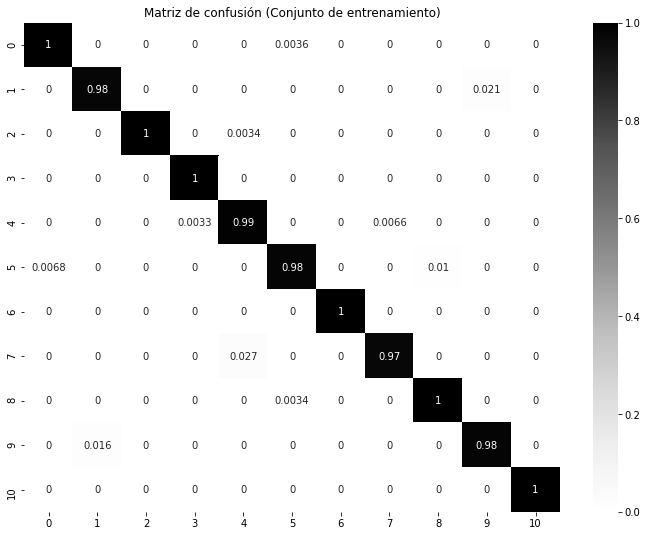

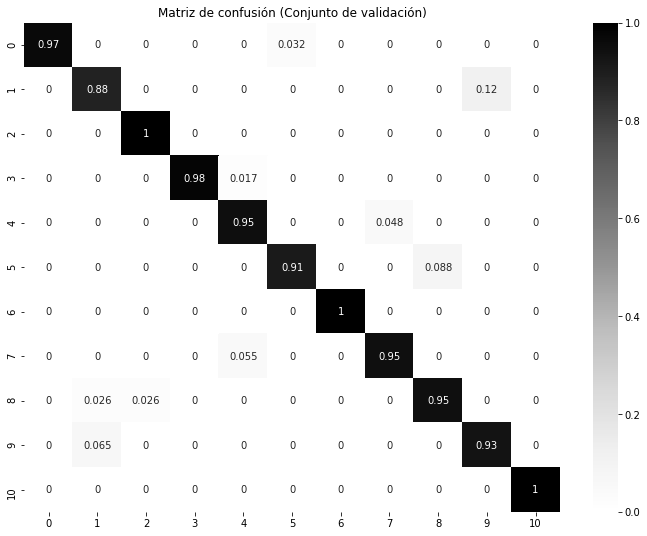

El accuracy del conjunto de entrenamiento es: 0.9907178217821783
El accuracy del conjunto de validación es: 0.9562171628721541


In [19]:
# f) 2 capas ocultas con 40 y 40 neuronas cada una y función de activación 
# ReLU, y 1000 épocas 

# Crear modelo 
model_6 = nn.Sequential(
          nn.Linear(48,40),
          nn.ReLU(),
          nn.Linear(40,40),
          nn.ReLU(),
          nn.Linear(40,11)
        )


# Función de pérdidas 
device_6 = torch.device('cuda')
model_6 = model_6.to(device_6)
criterion_6 = nn.CrossEntropyLoss()
optimizer_6 = torch.optim.Adam(model_6.parameters(), lr=1e-3)

#Entrenamiento
loss6_train=np.array([]) #Almacena los errores de entrenamiento
loss6_val=np.array([]) #Almacena los errores de validación
loss66_val=np.array([]) #Almacena los errores de validación

time6_0=time.time() #Hora inicial en segundos

for epoch in range(1000):
    try:
      model_6.train()

      # Train on the current epoch
      perd_train=np.array([])
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device_6)
          labels = data["labels"].to(device_6)
          # zero the parameter gradients
          optimizer_6.zero_grad()

          # forward + backward + optimize
          outputs = model_6(inputs)

          loss_t = criterion_6(outputs, labels)
          loss_t.backward() # Obtiene los gradientes y propaga
          optimizer_6.step() # Actualizan los pesos con los gradientes
          perd_train=np.append(perd_train,loss_t.item()) #Añade los errores a una lista
  
      prom_train=sum(perd_train)/len(perd_train)
      loss6_train=np.append(loss6_train,prom_train)  
        
      # Compute validation loss and accuracy for current epoch
      model_6.eval()

      if epoch%50==0:
        perd_val=np.array([]) 
      perd_val1=np.array([]) 
      with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device_6)
            labels = data["labels"].to(device_6)
            outputs = model_6(inputs)
            # Calcular loss de validación
            loss_v=criterion_6(outputs, labels)
            perd_val=np.append(perd_val,loss_v.item())
            perd_val1=np.append(perd_val1,loss_v.item())


      #Promedio error de validación cada época    
      prom_val1=sum(perd_val1)/len(perd_val1)
      loss66_val=np.append(loss66_val,prom_val1)

      #Muestra los erróres
      sys.stdout.write("\rÉpoca %d  "  %(epoch) + "Loss entrenamiento %s " %(prom_train) + "Loss validación %s " %(prom_val1))

      if epoch%50==0 or epoch==999:
        prom_val=sum(perd_val)/len(perd_val)
        loss6_val=np.append(loss6_val,prom_val)  

        #Guarda la red neuronal cada 50 épocas 
        torch.save(model_6, 'model_6_'+str(epoch)+'.pt')

        #Análisis de aumento en los errores de validación 
        l=len(loss6_val)
        if loss6_val[l-1]>loss6_val[l-2]:
          epoch_break_6=epoch
          break

      # Imprimir: numero de época, loss de entrenamiento y loss de validación
      # Se debe usar sys.stdout.write() para que la línea de texto se sobreescriba en vez de imprimirse línea por línea
      # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)

    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")
      break


print('\nEntrenamiento finalizado')
time6_1=time.time() #Hora final en segundos
time_train6=time6_1-time6_0 #Tiempo de entrenamiento
print('El tiempo de entrenamiento es: '+str(time_train6))

#Gráfico de errores
t_train=np.array(range(0,epoch_break_6-50)) #Épocas de entrenamiento
t_val=np.array(range(0,epoch_break_6-50))  #Épocas de validación
plt.plot(t_train,loss6_train[:epoch_break_6-50], label='Entrenamiento')
plt.plot(t_val,loss66_val[:epoch_break_6-50], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.title('Errores en la red neuronal')
plt.legend()
plt.grid()
plt.show()

#Mínimo del conjunto de validación
print(np.amin(loss6_val))

#Cargar red neuronal entrenada cuando el error de validación es mínimo 
model6_op=torch.load('model_6_'+str(epoch_break_6-50)+'.pt')

y_pred6_train = []
y_true6_train = []
y_pred6_val = []
y_true6_val = []

model6_op.eval()

with torch.no_grad():

    #Evalua en el conjunto de entrenamiento
    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device_6)
        labels = data["labels"].to(device_6)
        outputs = model6_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred6_train.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true6_train.extend(labels) # Save Truth
    
    #Evalua en el conjunto de validación
    for i, data in enumerate(dataloader_val, 0):
        inputs = data["features"].to(device_6)
        labels = data["labels"].to(device_6)
        outputs = model6_op(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred6_val.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true6_val.extend(labels) # Save Truth

#Matriz de confusión (Conjunto de entrenamiento)
matriz_cf6_train = confusion_matrix(y_true6_train, y_pred6_train, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf6_train, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de entrenamiento)')
plt.show()

#Matriz de confusión (Conjunto de validación)
matriz_cf6_val = confusion_matrix(y_true6_val, y_pred6_val, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf6_val, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de validación)')
plt.show()

#Accuracy conjunto de entrenamiento
accuracy6_train=accuracy_score(y_true6_train,y_pred6_train, normalize=True)
print('El accuracy del conjunto de entrenamiento es: '+str(accuracy6_train))

#Accuracy conjunto de validación
accuracy6_val=accuracy_score(y_true6_val,y_pred6_val, normalize=True)
print('El accuracy del conjunto de validación es: '+str(accuracy6_val))



# Parte 3
## Mejor Red neuronal 

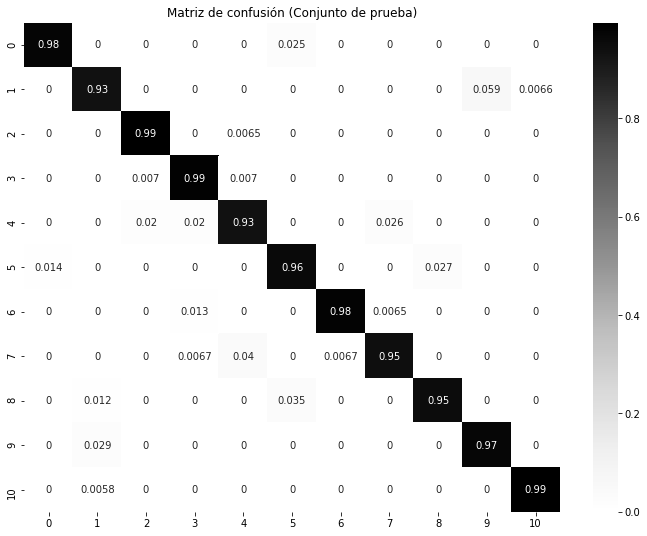

El accuracy del conjunto de prueba es: 0.9664113140836771


In [20]:
#Según los valores del accuracy se estableció que la mejor red neuronal es la compuesta por una 
# capa oculta con 40 neuronas y función de activación Tanh

#Cargar red neuronal entrenada cuando el error de validación es mínimo 
mejor_red=torch.load('model_4_'+str(epoch_break_4-50)+'.pt')

y_pred_test = []
y_true_test = []

mejor_red.eval()

with torch.no_grad():

    #Evalua en el conjunto de entrenamiento
    for i, data in enumerate(dataloader_test, 0):
        inputs = data["features"].to(device_4)
        labels = data["labels"].to(device_4)
        outputs = mejor_red(inputs)

        outputs = (torch.max(outputs.data, 1)[1]).data.cpu().numpy()
        y_pred_test.extend(outputs) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_test.extend(labels) # Save Truth
    
#Matriz de confusión (Conjunto de prueba)
matriz_cf_test = confusion_matrix(y_true_test, y_pred_test, normalize='true')
plt.figure(figsize=(12, 9))
sb.heatmap(matriz_cf_test, annot=True, cmap='Greys')
plt.title('Matriz de confusión (Conjunto de prueba)')
plt.show()

#Accuracy conjunto de prueba
accuracy_test=accuracy_score(y_true_test,y_pred_test, normalize=True)
print('El accuracy del conjunto de prueba es: '+str(accuracy_test))

